In [1]:
import os
import sys
from argparse import ArgumentParser
from glob import glob
from loguru import logger
from time import time
from tqdm import tqdm
from yaml import load, FullLoader

import pandas as pd
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from skimage import color
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog, match_descriptors, plot_matches, SIFT

In [2]:
sys.path.insert(1,'..')
import functions.fct_misc as misc
from functions.fct_rasters import remove_black_border

logger = misc.format_logger(logger)

# Processing

Load data

In [3]:
with open('../../config/config_symbol_classif.yaml') as fp:
    cfg = load(fp, Loader=FullLoader)['test_notebooks.py']

In [4]:
WORKING_DIR = cfg['working_dir']
OUTPUT_DIR = cfg['output_dir']
TILE_DIR = cfg['tile_dir']

In [5]:
os.chdir(WORKING_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
logger.info('Read data...')
tile_list = glob(os.path.join(TILE_DIR, '*.tif'))

2024-07-09 12:05:50 - INFO - Read data...


Prepare data

In [7]:
image_data = {}
for tile_path in tile_list:
    with rio.open(tile_path) as src:
        image_data[os.path.basename(tile_path)] = src.read().transpose(1, 2, 0)

In [8]:
data_gray = {key: color.rgb2gray(i) for key, i in image_data.items()}

Perform SIFT

In [9]:
descriptor_extractor = SIFT(n_octaves=1, n_scales=1, n_bins=50)
keypoints = {}
descriptors = {}
for name, image in data_gray.items():
    try:
        descriptor_extractor.detect_and_extract(image)
    except RuntimeError as e:
        if 'SIFT found no features.' in str(e):
            continue
        else:
            raise
    keypoints[name] = descriptor_extractor.keypoints
    descriptors[name] = descriptor_extractor.descriptors

In [10]:
test_match_self = match_descriptors(descriptors['0_2570184_1148461.tif'], descriptors['0_2570184_1148461.tif'], max_ratio=0.8, cross_check=True)

In [11]:
test_match_010 = match_descriptors(descriptors['0_2570184_1148461.tif'], descriptors['10_2580845_1165703.tif'], max_ratio=0.99, cross_check=True)

In [14]:
test_match_05 = match_descriptors(descriptors['0_2570184_1148461.tif'], descriptors['5_2569300_1148156.tif'], max_ratio=0.99, cross_check=True)

In [16]:
test_match_04 = match_descriptors(descriptors['0_2570184_1148461.tif'], descriptors['4_2569483_1149035.tif'], max_ratio=0.99, cross_check=True)

In [17]:
test_match_1b = match_descriptors(descriptors['2_2571560_1150039.tif'], descriptors['2_2571712_1150164.tif'], max_ratio=0.99, cross_check=True)


In [18]:
test_match_110 = match_descriptors(descriptors['1_2571614_1152259.tif'], descriptors['10_2580845_1165703.tif'], max_ratio=0.8, cross_check=True)

C:\Users\gwena\AppData\Local\Temp\ipykernel_3240\3919650301.py:3: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(ax[0, 0], data_gray['0_2570184_1148461.tif'], data_gray['0_2570184_1148461.tif'], keypoints['0_2570184_1148461.tif'], keypoints['0_2570184_1148461.tif'], test_match_self)
C:\Users\gwena\AppData\Local\Temp\ipykernel_3240\3919650301.py:7: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(ax[0, 1], data_gray['0_2570184_1148461.tif'], data_gray['10_2580845_1165703.tif'], keypoints['0_2570184_1148461.tif'], keypoints['10_2580845_1165703.tif'], test_match_010)
C:\Users\gwena\AppData\Local\Temp\ipykernel_3240\3919650301.py:11: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.p

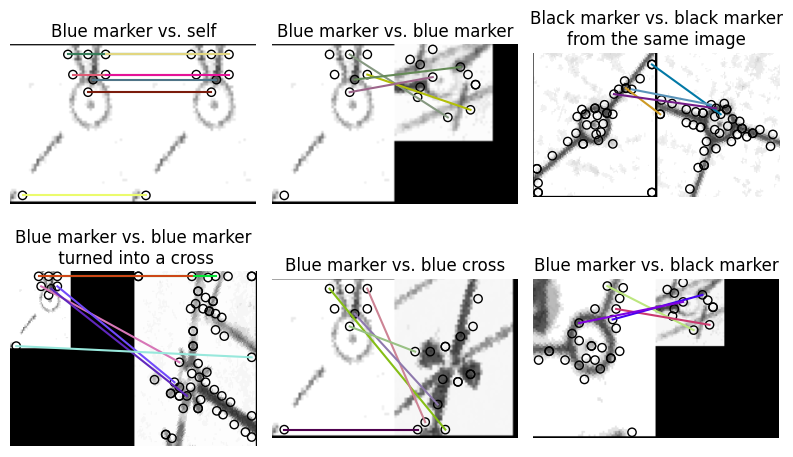

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

plot_matches(ax[0, 0], data_gray['0_2570184_1148461.tif'], data_gray['0_2570184_1148461.tif'], keypoints['0_2570184_1148461.tif'], keypoints['0_2570184_1148461.tif'], test_match_self)
ax[0, 0].axis('off')
ax[0, 0].set_title("Blue marker vs. self")

plot_matches(ax[0, 1], data_gray['0_2570184_1148461.tif'], data_gray['10_2580845_1165703.tif'], keypoints['0_2570184_1148461.tif'], keypoints['10_2580845_1165703.tif'], test_match_010)
ax[0, 1].axis('off')
ax[0, 1].set_title("Blue marker vs. blue marker")

plot_matches(ax[0, 2], data_gray['2_2571560_1150039.tif'], data_gray['2_2571712_1150164.tif'], keypoints['2_2571560_1150039.tif'], keypoints['2_2571712_1150164.tif'], test_match_010)
ax[0, 2].axis('off')
ax[0, 2].set_title("Black marker vs. black marker\n" "from the same image")


plot_matches(ax[1, 0], data_gray['0_2570184_1148461.tif'], data_gray['5_2569300_1148156.tif'], keypoints['0_2570184_1148461.tif'], keypoints['5_2569300_1148156.tif'], test_match_05)
ax[1, 0].axis('off')
ax[1, 0].set_title("Blue marker vs. blue marker\n" " turned into a cross")

plot_matches(ax[1, 1], data_gray['0_2570184_1148461.tif'], data_gray['4_2569483_1149035.tif'], keypoints['0_2570184_1148461.tif'], keypoints['4_2569483_1149035.tif'], test_match_04)
ax[1, 1].axis('off')
ax[1, 1].set_title("Blue marker vs. blue cross")


plot_matches(ax[1, 2], data_gray['1_2571614_1152259.tif'], data_gray['10_2580845_1165703.tif'], keypoints['1_2571614_1152259.tif'], keypoints['10_2580845_1165703.tif'], test_match_010)
ax[1, 2].axis('off')
ax[1, 2].set_title("Blue marker vs. black marker")

plt.tight_layout()